In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt

tickers = ["TSLA"]
start_date = "2015-07-01"
end_date = "2025-07-31"

tsla_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
tsla_data.ffill(inplace=True)
tsla_data.dropna(inplace=True)

split_point = int(len(tsla_data) * 0.9)
train_data = tsla_data[:split_point]
test_data = tsla_data[split_point:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

differenced_series = train_data.diff().dropna()

print("\n--- ADF Test on Differenced Series ---")
result = adfuller(differenced_series)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] <= 0.05:
    print("Conclusion: The differenced series is stationary.")
else:
    print("Conclusion: The differenced series is non-stationary.")


[*********************100%***********************]  1 of 1 completed

Training data size: 2281
Testing data size: 254

--- ADF Test on Differenced Series ---
ADF Statistic: -9.5577
p-value: 0.0000
Conclusion: The differenced series is stationary.



--- Finding optimal ARIMA parameters with auto_arima... ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14614.742, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14615.620, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14615.635, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14613.226, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14617.095, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.022 seconds

Best ARIMA Parameters: (0, 1, 0)

--- Forecasting with the ARIMA model... ---

--- ARIMA Model Performance Metrics ---
RMSE: 13.2148
MAE: 9.7719
MAPE: 3.2827%


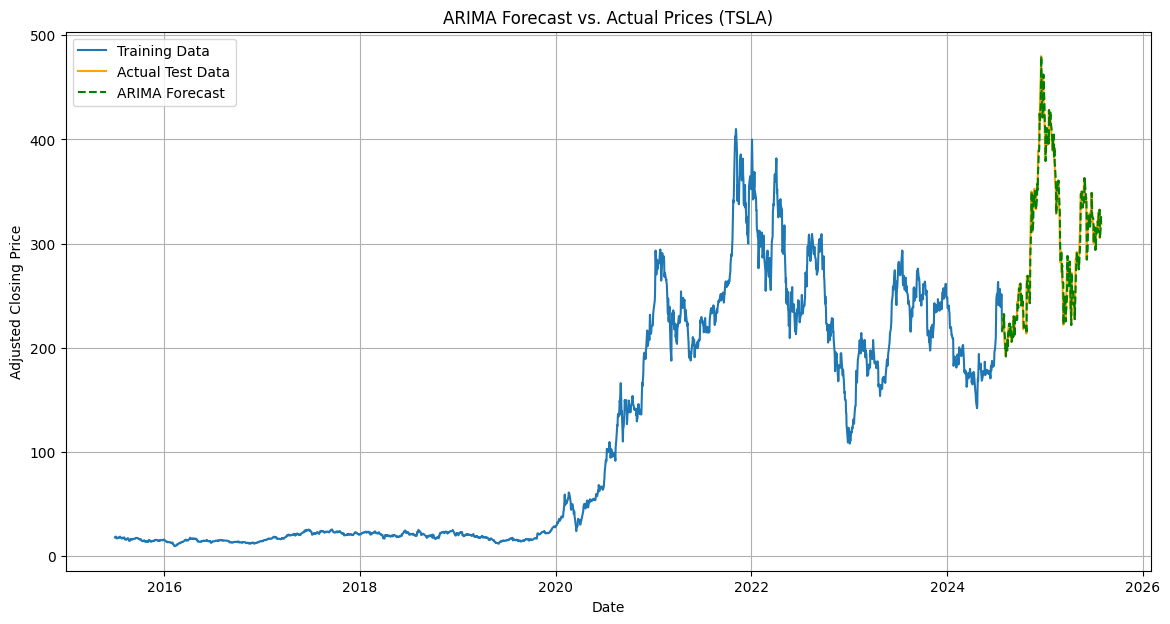

In [4]:
# --- Building and Training the ARIMA Model ---
print("\n--- Finding optimal ARIMA parameters with auto_arima... ---")
auto_model = auto_arima(train_data, start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        m=1, d=1, D=0,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(f"\nBest ARIMA Parameters: {auto_model.get_params()['order']}")

# --- Forecasting with the ARIMA Model ---
print("\n--- Forecasting with the ARIMA model... ---")
history = [x for x in train_data.values]
predictions = list()

for t in range(len(test_data)):
    model_fit = auto_model.fit(history)
    output = model_fit.predict(n_periods=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data.values[t]
    history.append(obs)

forecast_arima = pd.Series(predictions, index=test_data.index)

# --- Model Evaluation ---
print("\n--- ARIMA Model Performance Metrics ---")
combined_data = pd.DataFrame({'test': test_data.squeeze(), 'forecast': forecast_arima})
combined_data.dropna(inplace=True)

if not combined_data.empty:
    test_data_for_eval = combined_data['test']
    forecast_arima_for_eval = combined_data['forecast']

    rmse_arima = np.sqrt(mean_squared_error(test_data_for_eval, forecast_arima_for_eval))
    mae_arima = mean_absolute_error(test_data_for_eval, forecast_arima_for_eval)
    mape_arima = np.mean(np.abs((test_data_for_eval - forecast_arima_for_eval) / test_data_for_eval)) * 100

    print(f"RMSE: {rmse_arima:.4f}")
    print(f"MAE: {mae_arima:.4f}")
    print(f"MAPE: {mape_arima:.4f}%")

    # --- Visualization of ARIMA Forecast ---
    plt.figure(figsize=(14, 7))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, label='Actual Test Data', color='orange')
    plt.plot(forecast_arima, label='ARIMA Forecast', color='green', linestyle='--')
    plt.title('ARIMA Forecast vs. Actual Prices (TSLA)')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ARIMA model could not produce a valid forecast for evaluation.")


[*********************100%***********************]  1 of 1 completed
c:\Users\josib\Documents\GMF_Portfolio_Optimization\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1850/1850 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 0.0043
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
RMSE: 22.8810
MAE: 19.2006
MAPE: 8.6737%


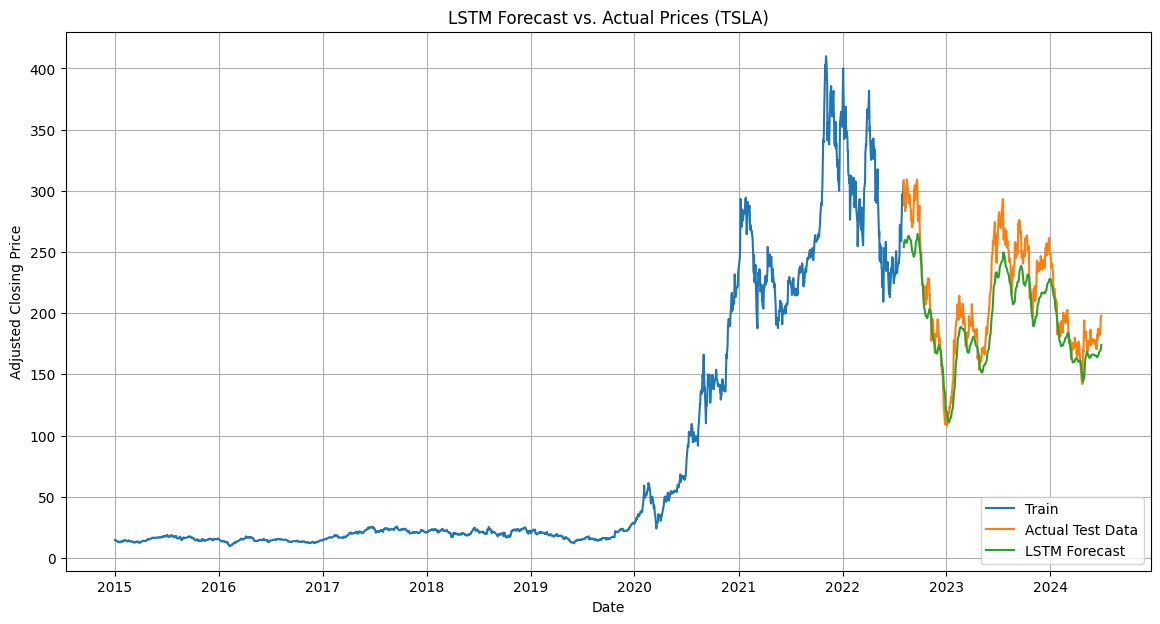

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime

ticker_symbol = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-06-30'

data = yf.download(ticker_symbol, start=start_date, end=end_date, auto_adjust=True)
data.dropna(inplace=True)

train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

training_data_len = len(train_data)
test_data_len = len(test_data)

train_scaled_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []
sequence_length = 60
for i in range(sequence_length, len(train_scaled_data)):
    x_train.append(train_scaled_data[i-sequence_length:i, 0])
    y_train.append(train_scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(x_train, y_train, batch_size=1, epochs=1)

test_scaled_data = scaled_data[training_data_len - sequence_length:, :]
x_test = []
for i in range(sequence_length, len(test_scaled_data)):
    x_test.append(test_scaled_data[i-sequence_length:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = lstm_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse_lstm = np.sqrt(mean_squared_error(test_data['Close'].values, predictions))
mae_lstm = mean_absolute_error(test_data['Close'].values, predictions)
mape_lstm = np.mean(np.abs((test_data['Close'].values - predictions) / test_data['Close'].values)) * 100

print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"MAPE: {mape_lstm:.4f}%")

train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions
plt.figure(figsize=(14, 7))
plt.title('LSTM Forecast vs. Actual Prices (TSLA)')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual Test Data', 'LSTM Forecast'], loc='lower right')
plt.grid(True)
plt.show()
